In [35]:
## LIBRARY
import glob
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.filters import try_all_threshold
from skimage.filters import threshold_minimum
from skimage.filters import threshold_triangle
from skimage.morphology import binary_erosion, binary_dilation
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.segmentation import clear_border
from skimage.segmentation import relabel_sequential
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from statistics import mean
from natsort import natsorted
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [5]:
## CLEAN VERSION
filename = 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/Tereza/Beating_hearts_tiff'
list_of_FAP_files = natsorted(glob.glob(f"{filename}/*FAP*.tif"))
list_of_CD19_files = natsorted(glob.glob(f"{filename}/*CD19*.tif"))

masks_FAP = []
masks_CD19 = []

threshold_intensity_value = 250
threshold_small_objects = 100000
area_threshold = 3000

for file in list_of_FAP_files:
    img = io.imread(file)
    img_new = img > threshold_intensity_value
    img_inverted = np.invert(img_new)
    cleaned_mask = remove_small_holes(img_inverted, area_threshold = area_threshold)
    mask_1 = remove_small_objects(cleaned_mask, min_size=threshold_small_objects)
    masks_FAP.append(mask_1)
    
for file in list_of_CD19_files:
    img = io.imread(file)
    img_new = img > threshold_intensity_value
    img_inverted = np.invert(img_new)
    cleaned_mask = remove_small_holes(img_inverted, area_threshold=area_threshold)
    mask_2 = remove_small_objects(cleaned_mask, min_size=threshold_small_objects)
    masks_CD19.append(mask_2)


['C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/Tereza/Beating_hearts_tiff\\20250307_CARS_videos_d36ET1_Tcells_added_24h_before_treatment.lif - FAP 1_25 10X.tif', 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/Tereza/Beating_hearts_tiff\\20250307_CARS_videos_d36ET1_Tcells_added_24h_before_treatment.lif - FAP 1_50 10X.tif', 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/Tereza/Beating_hearts_tiff\\20250307_CARS_videos_d36ET1_Tcells_added_24h_before_treatment.lif - FAP 1_100 10X.tif']
(153, 2048, 2048)


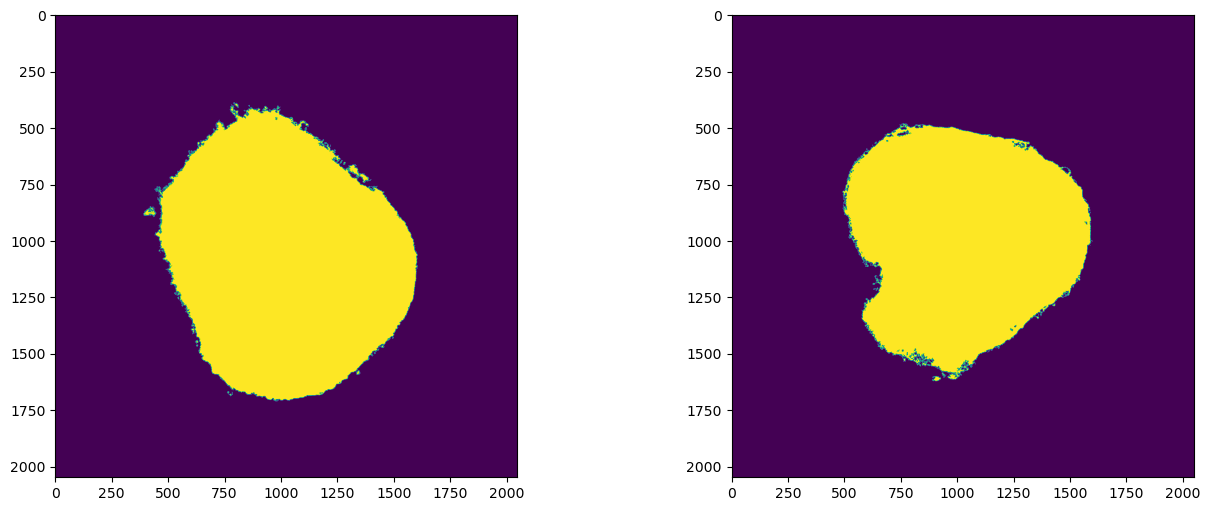

In [ ]:
## Control:
print(list_of_FAP_files)
print(masks_FAP[0].shape)
# Thresholding tryouts
fig, axs = plt.subplots(ncols=2, figsize=(16,6))
axs[0].imshow(masks_FAP[0][100])
axs[1].imshow(masks_FAP[1][100])

In [9]:
## AREA analysis
pixel_size_microns = 0.65

FAP_areas = []
for mask in masks_FAP:
    areas_in_um2 = []
    for i in range(len(mask)):
        area_singular = np.sum(mask[i])
        area_um2 = area_singular * (pixel_size_microns ** 2)
        areas_in_um2.append(area_um2)
    FAP_areas.append(areas_in_um2)

CD19_areas = []
for mask in masks_CD19:
    areas_in_um2 = []
    for i in range(len(mask)):
        area_singular = np.sum(mask[i])
        area_um2 = area_singular * (pixel_size_microns ** 2)
        areas_in_um2.append(area_um2)
    CD19_areas.append(areas_in_um2)

In [12]:
## EXPORT to excel
df_FAP = pd.DataFrame({'area_1_25': FAP_areas[0], 
                       'area_1_50': FAP_areas[1],
                       'area_1_100': FAP_areas[2]
                   })

df_CD19 = pd.DataFrame({'area_1_25': FAP_areas[0], 
                       'area_1_50': FAP_areas[1],
                       'area_1_100': FAP_areas[2]
                   })

df_FAP.to_excel('FAP_areas.xlsx', index=False)
df_CD19.to_excel('CD19_areas.xlsx', index=False)

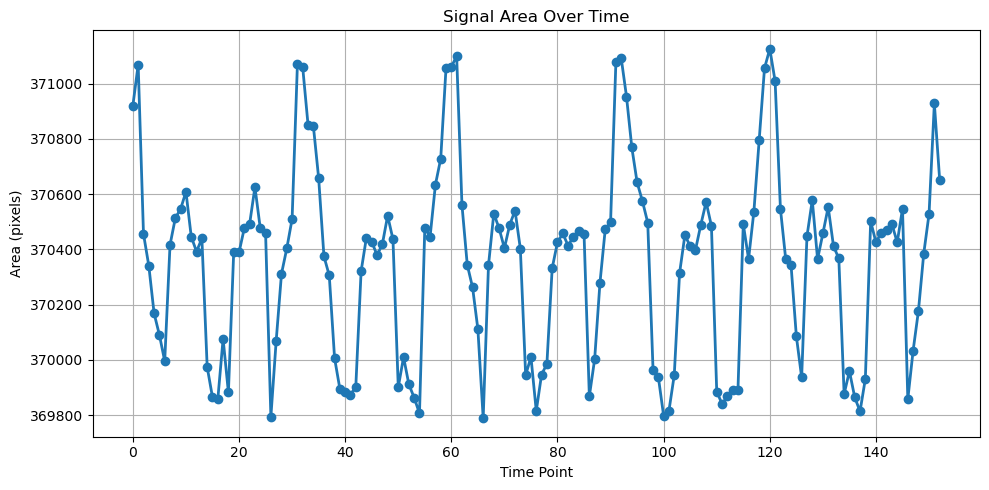

In [17]:
## Plotting
plt.figure(figsize=(10, 5))
plt.plot(FAP_areas[1], marker='o', linewidth=2)
plt.title("Signal Area Over Time")
plt.xlabel("Time Point")
plt.ylabel("Area (pixels)")
plt.grid(True)
plt.tight_layout()
plt.show()

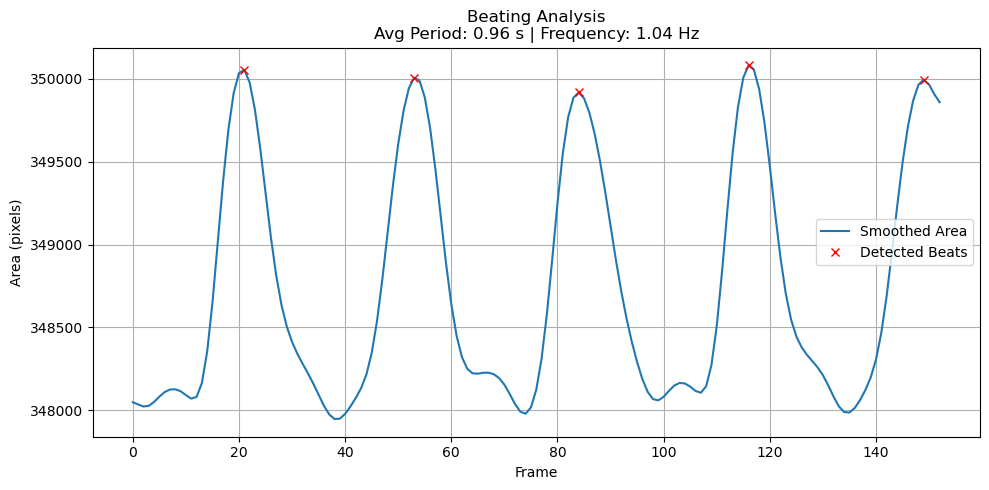

Average period between beats: 0.96 seconds
Estimated beating frequency: 1.04 Hz


In [47]:
## Beating analysis:

# --- PARAMETERS ---
voxel_duration = 0.030  # seconds per frame (your voxel size)

# --- YOUR INPUT DATA ---
# Optional: smooth the signal to reduce noise
areas_smooth = gaussian_filter1d(FAP_areas[2], sigma=2)

# --- PEAK DETECTION ---
# Tune distance/prominence based on your data
peaks, _ = find_peaks(areas_smooth, distance=15, prominence=15)

# --- TIME ANALYSIS ---
# Time between beats (in frames)
peak_intervals_frames = np.diff(peaks)

# Convert to seconds using voxel size
peak_intervals_seconds = peak_intervals_frames * voxel_duration

# Average period and frequency
average_period_sec = np.mean(peak_intervals_seconds)
average_frequency_hz = 1 / average_period_sec

# --- PLOT ---
plt.figure(figsize=(10, 5))
plt.plot(areas_smooth, label='Smoothed Area')
plt.plot(peaks, areas_smooth[peaks], "rx", label='Detected Beats')
plt.title(f"Beating Analysis\nAvg Period: {average_period_sec:.2f} s | Frequency: {average_frequency_hz:.2f} Hz")
plt.xlabel("Frame")
plt.ylabel("Area (pixels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PRINT RESULTS ---
print(f"Average period between beats: {average_period_sec:.2f} seconds")
print(f"Estimated beating frequency: {average_frequency_hz:.2f} Hz")



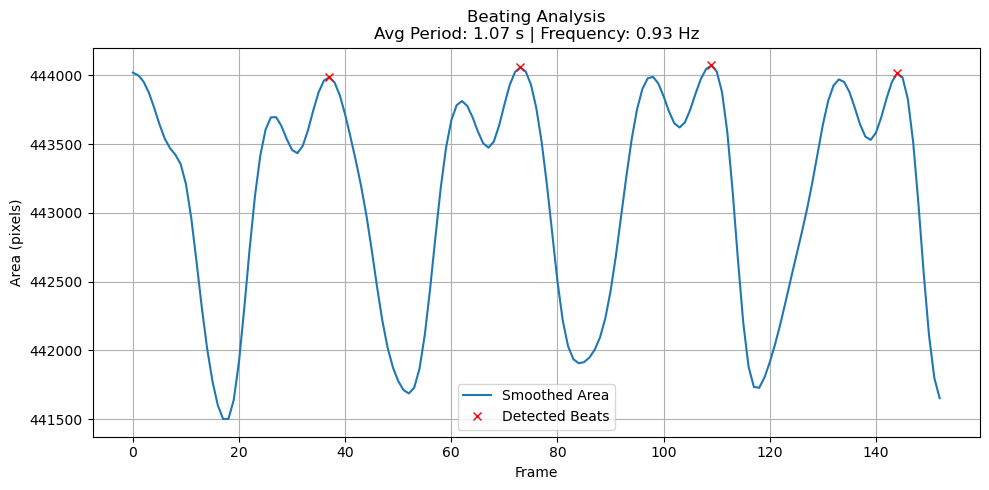

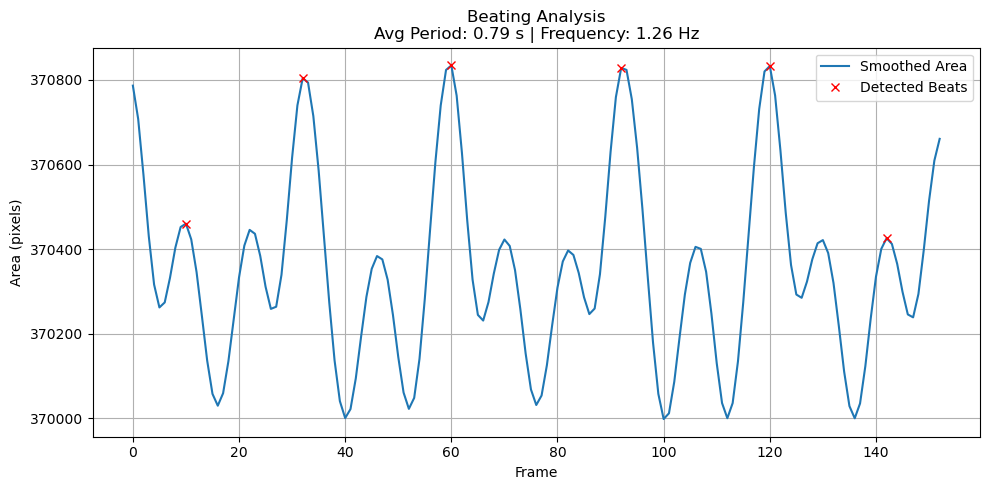

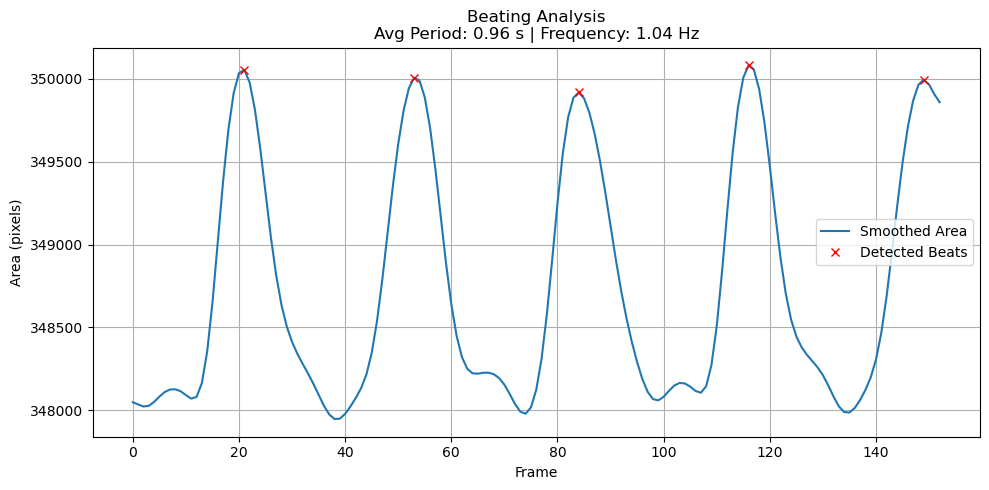

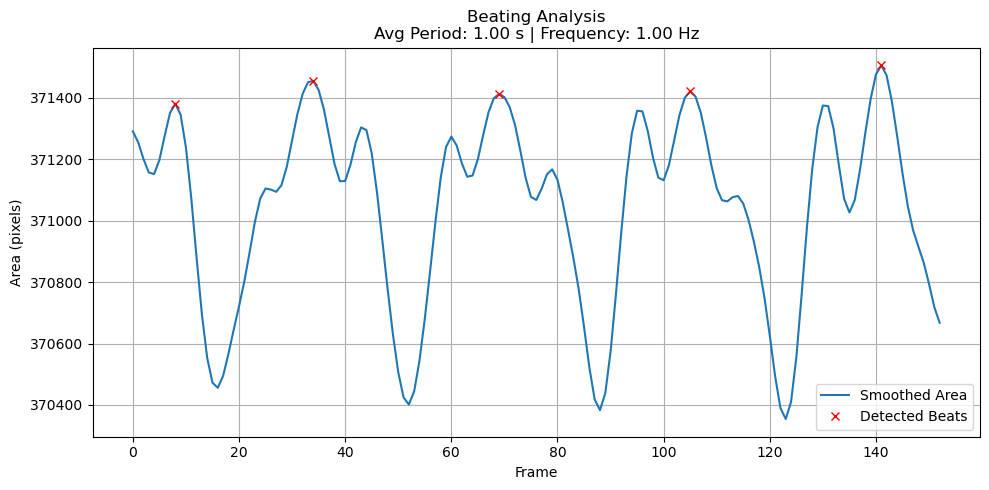

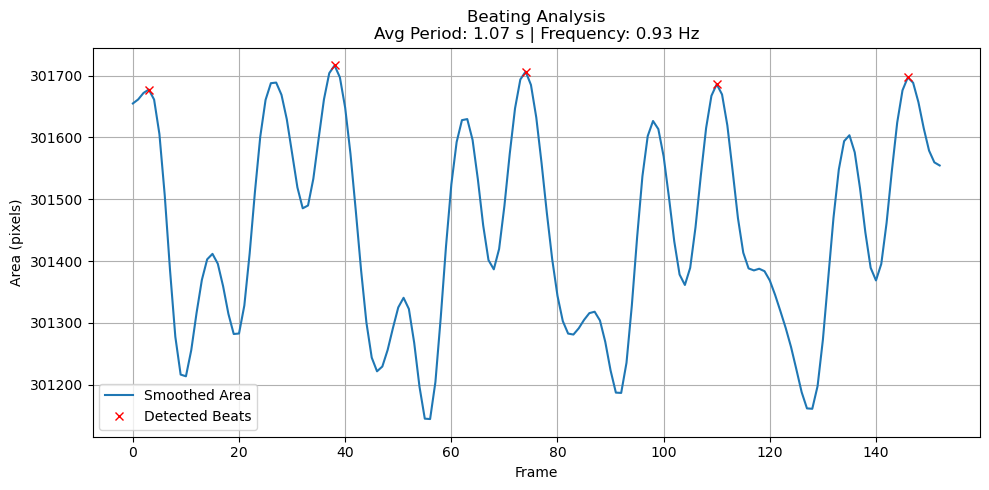

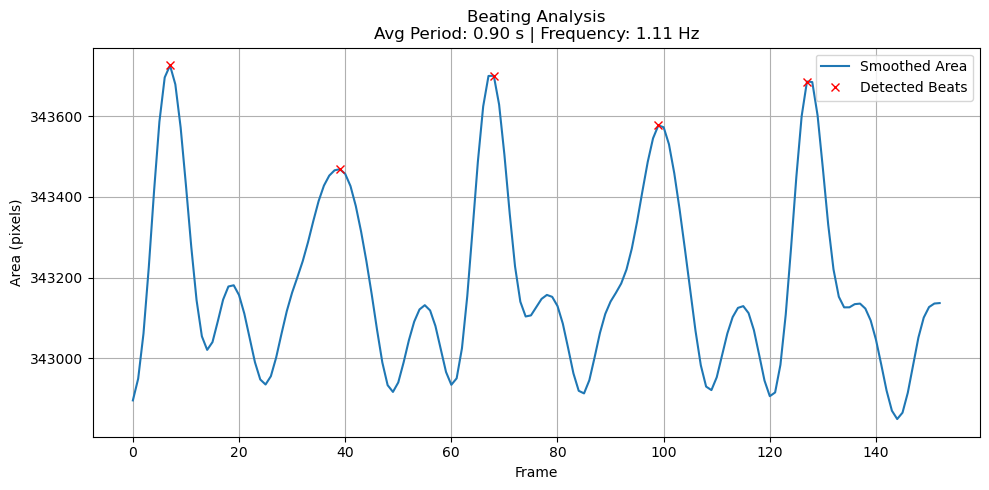

In [54]:
## Export to excel:
FAP_analysis = []
for i in range(len(FAP_areas)):
    areas_smooth = gaussian_filter1d(FAP_areas[i], sigma=2)
    peaks, _ = find_peaks(areas_smooth, distance=15, prominence=15)
    peak_intervals_frames = np.diff(peaks)
    peak_intervals_seconds = peak_intervals_frames * voxel_duration
    average_period_sec = np.mean(peak_intervals_seconds)
    average_frequency_hz = 1 / average_period_sec

    plt.figure(figsize=(10, 5))
    plt.plot(areas_smooth, label='Smoothed Area')
    plt.plot(peaks, areas_smooth[peaks], "rx", label='Detected Beats')
    plt.title(f"Beating Analysis\nAvg Period: {average_period_sec:.2f} s | Frequency: {average_frequency_hz:.2f} Hz")
    plt.xlabel("Frame")
    plt.ylabel("Area (pixels)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"beating_analysis_FAP_{i}.png", dpi=300)

    FAP_dict = {'average_period_sec':average_period_sec,
                'average_frequency_hz':average_frequency_hz}
    FAP_analysis.append(FAP_dict)


CD19_analysis = []
for i in range(len(CD19_areas)):
    areas_smooth = gaussian_filter1d(CD19_areas[i], sigma=2)
    peaks, _ = find_peaks(areas_smooth, distance=15, prominence=15)
    peak_intervals_frames = np.diff(peaks)
    peak_intervals_seconds = peak_intervals_frames * voxel_duration
    average_period_sec = np.mean(peak_intervals_seconds)
    average_frequency_hz = 1 / average_period_sec

    plt.figure(figsize=(10, 5))
    plt.plot(areas_smooth, label='Smoothed Area')
    plt.plot(peaks, areas_smooth[peaks], "rx", label='Detected Beats')
    plt.title(f"Beating Analysis\nAvg Period: {average_period_sec:.2f} s | Frequency: {average_frequency_hz:.2f} Hz")
    plt.xlabel("Frame")
    plt.ylabel("Area (pixels)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"beating_analysis_CD19_{i}.png", dpi=300)

    CD19_dict = {'average_period_sec':average_period_sec,
                'average_frequency_hz':average_frequency_hz}
    CD19_analysis.append(CD19_dict)

In [53]:
## EXPORT to excel
print(FAP_analysis[0]['average_frequency_hz'])

df_FAP = pd.DataFrame({'average_period_sec_1_25': FAP_analysis[0]['average_period_sec'], 
                       'average_period_sec_1_50': FAP_analysis[1]['average_period_sec'],
                       'average_period_sec_1_100': FAP_analysis[2]['average_period_sec'],
                       'average_frequency_hz_1_25': FAP_analysis[0]['average_frequency_hz'], 
                       'average_frequency_hz_1_50': FAP_analysis[1]['average_frequency_hz'],
                       'average_frequency_hz_1_100': FAP_analysis[2]['average_frequency_hz']
                   }, index=[0])

df_CD19 = pd.DataFrame({'average_period_sec_1_25': CD19_analysis[0]['average_period_sec'], 
                       'average_period_sec_1_50': CD19_analysis[1]['average_period_sec'],
                       'average_period_sec_1_100': CD19_analysis[2]['average_period_sec'],
                       'average_frequency_hz_1_25': CD19_analysis[0]['average_frequency_hz'], 
                       'average_frequency_hz_1_50': CD19_analysis[1]['average_frequency_hz'],
                       'average_frequency_hz_1_100': CD19_analysis[2]['average_frequency_hz']
                   }, index=[0])

df_FAP.to_excel('FAP_analysis.xlsx', index=False)
df_CD19.to_excel('CD19_analysis.xlsx', index=False)

0.9345794392523364
